In [25]:
# Model definition
import os
import numpy as np
import pandas as pd
import scipy
import time

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from scipy.stats import norm
# SKLEARN
from sklearn.preprocessing  import ( StandardScaler, )
from sklearn.model_selection import ( train_test_split,KFold,cross_val_score, )

#KERAS 
import keras as ks
from keras import backend as K
from keras import models
from keras import layers
from keras import (Input,)
from keras.applications import (VGG16,vgg19,inception_v3,)
from keras.callbacks import (ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,CSVLogger,)
from keras.datasets import (boston_housing,mnist, imdb,)
from keras.layers import (Layer,Dense,Flatten,Embedding, SimpleRNN, LSTM, GRU, MaxPooling1D, Conv1D, GlobalMaxPooling1D )
from keras.models import (load_model,Model,Sequential, )
from keras.optimizers import (RMSprop,)
from keras.preprocessing.image import (ImageDataGenerator,image,img_to_array, load_img,)
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor


import matplotlib.pyplot as plt
%matplotlib inline

from utils import timeit


# Step 1: Encode

In [10]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2                                     

input_img = Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)               
z_log_var = layers.Dense(latent_dim)(x) 



# Step 2: Sample

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Step 3: Decoder

In [13]:
decoder_input = layers.Input(K.int_shape(z)[1:])                

# unsample the input
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)              

x = layers.Reshape(shape_before_flattening[1:])(x)              
x = layers.Conv2DTranspose(32, 3,                               
                           padding='same',                      
                           activation='relu',                   
                           strides=(2, 2))(x)                   
x = layers.Conv2D(1, 3, padding='same',activation='sigmoid')(x)                      

decoder = Model(decoder_input, x)                          

z_decoded = decoder(z) 

In [20]:
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = ks.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):                               
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x                                          

y = CustomVariationalLayer()([input_img, z_decoded])      

# Training

In [21]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)
(1, 2)
(16, 2)


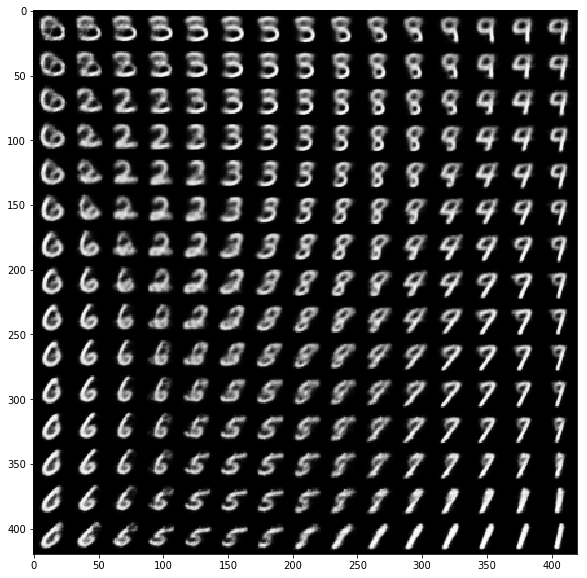

In [29]:
n = 15                                                                    
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))                             
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))                             

print(grid_x)
print(grid_y)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # repeat sample
        print(z_sample.shape)
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)   
        print(z_sample.shape)
        #predict random point
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)      
        digit = x_decoded[0].reshape(digit_size, digit_size)              
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [33]:
arr = np.array([1,2])
print(arr)
print(np.tile(arr,10))
print(np.tile(arr,10).reshape(10,2))


[1 2]
[1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]
[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]]
